In [1]:
from tqdm import tqdm
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import hdbscan 
import seaborn as sns

# Principal component analysis (PCA) for full length FAT10
In this notebook, a PCA is performed for the closeness centralities calculated in  [1_Calculating_Closeness_Centralities_full_length_FAT10.ipynb](./1_Calculating_Closeness_Centralities_full_length_FAT10.ipynb). 


The two-dimensional embedding is then clustered using the density-based clustering algorithm [HDBSCAN (Hierarchical density based clustering for applications with noise)](https://hdbscan.readthedocs.io/en/latest/index.html#).  

The resulting clusters are analyzed by projecting them into the map that is colored by different structural descriptors of FAT10 and by calculating the mean closeness centralities for the clusters.  

Representative structures for the clusters are selected and saved.  


## Loading the closness centralities 

In [2]:
closeness = np.load("./Closeness_Centralities_full_length_FAT10.npy")

## Principal component analysis (PCA)

To perform the PCA, the implementation in scikit-learn was used. Please refer to [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for further details. 

In [3]:
pca = PCA(n_components=2) # Selecting the first two principal components for dimensionality reduction
pca_embedding = pca.fit_transform(closeness)

## Plotting the first two principal components and coloring based on log(density) in a hexbin plot

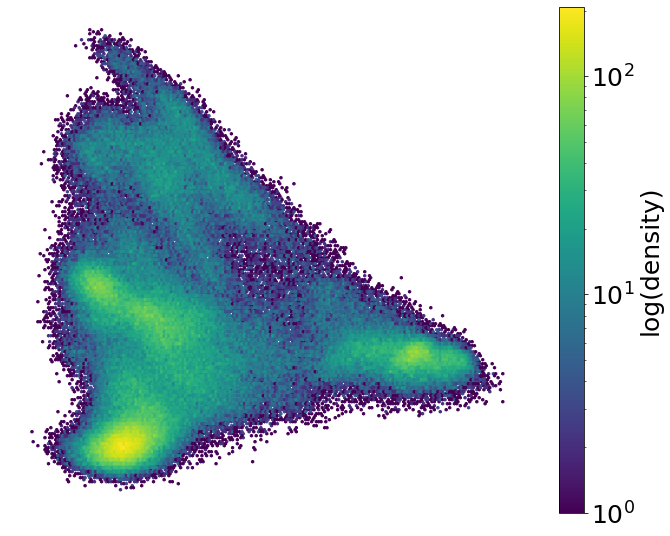

In [5]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),
                       tight_layout = True)
hex_map = ax.hexbin(pca_embedding[:,0], 
                    pca_embedding[:,1],
                    cmap = 'viridis', 
                    bins = 'log', 
                    mincnt =1, 
                    gridsize = 200)

ax.set_axis_off()
cb = plt.colorbar(hex_map, 
                  label = "log(density)")
cb.set_alpha(1)
cb.draw_all()

## HDBSCAN Clustering 
The parameters were selected to give a global overview of the residue interaction landscape. 

For details on the HDBSCAN parameters, please refer to https://hdbscan.readthedocs.io/en/latest/parameter_selection.html. 


In [6]:
clusterer        = hdbscan.HDBSCAN(min_cluster_size=100, 
                                   min_samples=800, 
                                   cluster_selection_method='eom')
clusterer.fit(pca_embedding)
cluster_ids_PCA           = clusterer.labels_

## Loading the trajectory and calculating the radius of gyration (Rg) for FAT10
The Rg serves as a metric for the compactness of the two-domain protein, which gives an indication to what extent the two domains are in contact. 

High Rg indicates few or no contacts between the domains. Low Rg values indicate that the two domains have collapsed on top of one another, forming compact, closed conformations.

In [7]:
topology_file = "./start_frame_FAT10.pdb"
traj_file = "./FAT10_123_traj_center_dt100.xtc"

traj = md.load(traj_file, top = topology_file)

Rg =  md.compute_rg(traj)

In [8]:
# Defintion of a custom colormap to enable specific coloring of the KDE Plot
cmap = plt.cm.get_cmap("magma", 5)

## Plotting the PCA and coloring based on Rg, overlaid by the outlines of the clusters. 
The hexbin coloring is made according to the average value of the Rg across the frames in each hexagonal bin. 

The cluster outlines are created using the first level of a KDE Plot. 

Points outside of the outlines are classified as noise (Cluster ID -1) by HDBSCAN.  

Otherwise, the cluster numbering is not inherently meaningful.

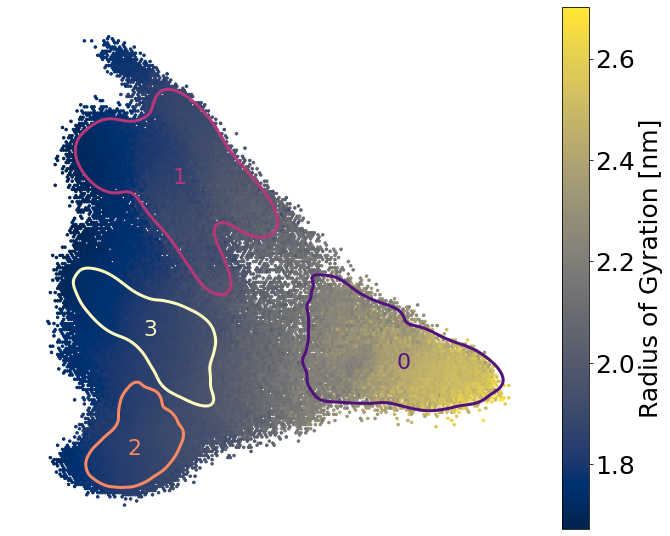

In [9]:
%matplotlib inline

# Hexbin plot of the PCA of the closeness centralities, colored by Radius of gyration (Rg)
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),
                       tight_layout = True)
hex_map = ax.hexbin(pca_embedding[:, 0], 
                    pca_embedding[:, 1],
                    C = Rg,
                    cmap = 'cividis', 
                    mincnt =1, 
                    gridsize = 200)
ax.set_axis_off()
cb = plt.colorbar(hex_map, label = "Radius of Gyration [nm]")
cb.set_alpha(1)
cb.draw_all()

#Overlay the cluster outlines
for cluster in range(4): 
    if cluster > -1:
        cluster_points = pca_embedding[np.where(cluster_ids_PCA == cluster)][::10]
        kdeplot = sns.kdeplot(x = cluster_points[:,0], 
                    y = cluster_points[:,1], 
                    fill = False,
                    levels = 1,
                    color = cmap(cluster+1), 
                    linewidths =3)
        kdeplot.clabel = "102"
        cluster_center_x = np.mean(pca_embedding[np.where(cluster_ids_PCA == cluster), 0])
        cluster_center_y = np.mean(pca_embedding[np.where(cluster_ids_PCA == cluster), 1])
        ax.text(cluster_center_x, 
                cluster_center_y,  
                cluster, 
                horizontalalignment='center',
                verticalalignment='center',
                size = 22, 
                color = cmap(cluster+1))

## Plotting the mean closeness centralities for clusters 0,1 and 2

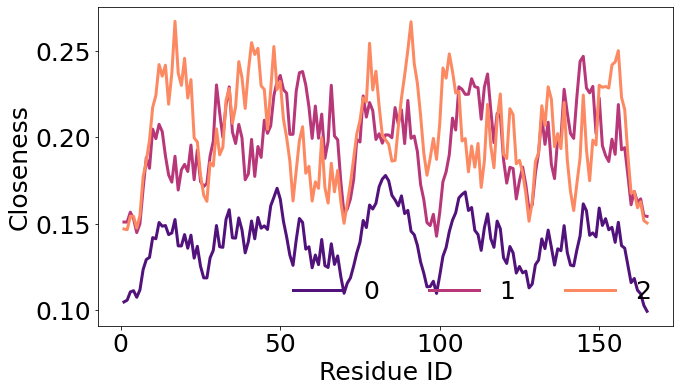

In [25]:
plt.rcParams.update({'font.size': 25}) 
fig, ax = plt.subplots(figsize = (10,6),tight_layout = True) 
plt.ylabel('Closeness') 
plt.xlabel('Residue ID') 
for cluster in [0,1,2]: 
    frames_in_cluster = np.where(cluster_ids_PCA == cluster)[0] 
    mean_closeness = np.mean(closeness[frames_in_cluster], axis = 0) 
    x_values = np.arange(1, len(mean_closeness) + 1)
    ax.plot(x_values, 
            mean_closeness,
            color = cmap(cluster+1), 
            label = str(cluster), 
            linewidth =3)   
    ax.ylim =(0.1,0.33)
    ax.legend(loc = "lower right", ncol =4, framealpha = 0) 
    ax.grid(False) 

## Plotting of cluster IDs and 10 cluster representatives sampled from the clusters (shown in blue)
Cluster representatives are sampled as every n-th frame from the cluster based on the cluster size, where n is given by the cluster size and the selected number of representatives. 
For example, for a cluster with 5000 members, every 500th frame is selected to give 10 representatives. 

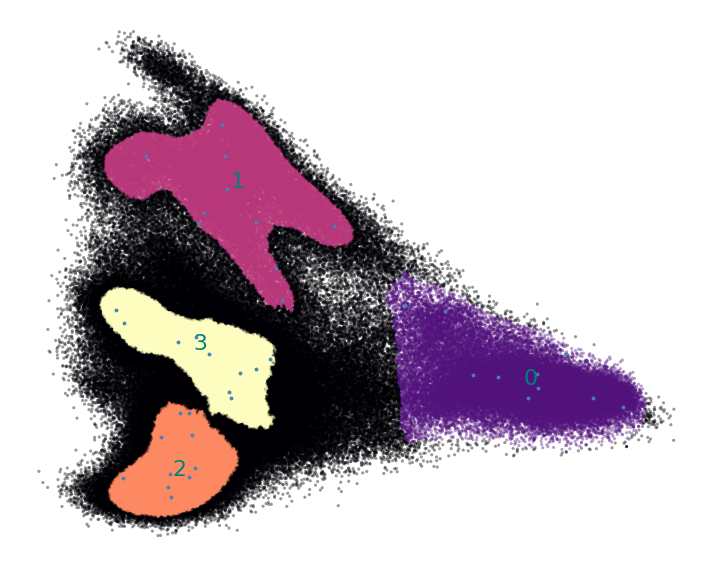

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
# Plotting the PCA colored bvy cluster ID 
ax.scatter(pca_embedding[:, 0], pca_embedding[:, 1],
           s=10, 
           marker="o", 
           linewidths=0, 
           alpha = 0.4,
           c = cluster_ids_PCA, 
           cmap = cmap)
for cluster in np.unique(cluster_ids_PCA): 
    if cluster > -1:
        cluster_center_x = np.mean(pca_embedding[np.where(cluster_ids_PCA == cluster), 0])
        cluster_center_y = np.mean(pca_embedding[np.where(cluster_ids_PCA == cluster), 1])
        ax.text(cluster_center_x, cluster_center_y, cluster, size = 22, color = "teal" )
ax.set_axis_off()

#Selecting and plotting 10 cluster representatives (blue)
number_of_representatives = 10
for cluster in np.unique(cluster_ids_PCA): 
    if (cluster > -1): 
        frames_in_cluster = np.where(cluster_ids_PCA == cluster)[0]
        cluster_size = frames_in_cluster.shape[0]
        if (cluster_size > number_of_representatives): 
            reduction_factor = int(np.ceil(cluster_size/number_of_representatives))
            cluster_representatives = frames_in_cluster[::reduction_factor]
        else: 
            cluster_representatives = frames_in_cluster
        plt.scatter(pca_embedding[cluster_representatives, 0], 
                    pca_embedding[cluster_representatives, 1], 
                    color = 'steelblue', 
                    marker = 'o', 
                    s = 8)

## Writing out the PDB files for 10 cluster representatives aligned on top of the first representative

In [12]:
number_of_representatives = 10
for cluster in tqdm(np.unique(cluster_ids_PCA)): 
    if cluster > -1: 
        frames_in_cluster = np.where(cluster_ids_PCA == cluster)[0]
        cluster_size = frames_in_cluster.shape[0]
        if (cluster_size > number_of_representatives): 
            reduction_factor = int(np.ceil(cluster_size/number_of_representatives))
            cluster_representatives = frames_in_cluster[::reduction_factor]
        else: 
            cluster_representatives = frames_in_cluster
        
        cluster_representatives_structures = traj[cluster_representatives].superpose(reference=traj[cluster_representatives[0]])
        cluster_representatives_structures.save_pdb("Cluster_Represemtatives_PCA/Cluster_Representatives_Cluster_{}.pdb".format(cluster))

100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


# Calculating and plotting a numeric descriptor for the domain interface

To get a quick overview of how the two domains of FAT10 interact, a numeric description of the domain interface is calculated here. 
First the numbe of contacts with the C-terminal domain (CD) is calculated for each residue in the N-terminal domain (ND).
Then, the N-terminal domain is split into two sections between residue Val43 and residue Pro44. The contacts with the C-domain are summed up separately for each section and then subtracted from each other. This means, high contact counts of one section with the CD result in a high and positive domain interface metric. High contact counts of the other section with the CD result in a negative domain interface metric. If the contact counts are mixed or there are no contacts, the metric will be close to zero. 

## Defining the domain limits for calculating the contact count between the domains

In [13]:
ND_start_res = 7
ND_end_res = 79
CD_start_res = 87
CD_end_res = 159

## Defining the distance thresholds and the frame numbers for the contact calculation. 
These are the same parameters as for the closeness centrality calculation. 

In [14]:
thresh_low = 0.0
thresh_high = 0.45
n_frames = 300150
chunksize = 2001

## Calculating the contacts between each residue of the N-Domain with all residues of the C-domain
Here, the same process as for calculating the contacts for the closeness centrality is used. Please refer to [1_Calculating_Closeness_Centralities_full_length_FAT10.ipynb](./1_Calculating_Closeness_Centralities_full_length_FAT10.ipynb) for more details.


In [15]:
contacts_ND_with_CD = np.zeros((n_frames, ND_end_res-ND_start_res))
for chunk_id, chunk in tqdm(enumerate(md.iterload(traj_file, top = topology_file, chunk = chunksize))):
    # Calculating the contact adjacency matrices as before
    distances, residue_pairs =  md.compute_contacts(chunk, scheme = 'sidechain') 
    distance_matrices = md.geometry.squareform(distances, residue_pairs)
    adjacency_matrices = np.logical_and(distance_matrices > thresh_low, 
                                        distance_matrices< thresh_high)
    #Summing up the contacts of each residue in the ND with all residues in the CD. 
    for frame in range(adjacency_matrices.shape[0]):
        for index, residue in enumerate(np.arange(ND_start_res, ND_end_res)):
            contacts_ND_with_CD[frame+chunksize*chunk_id, index] = np.sum(adjacency_matrices[frame, residue, CD_start_res:CD_end_res])
    

150it [4:21:00, 104.40s/it]


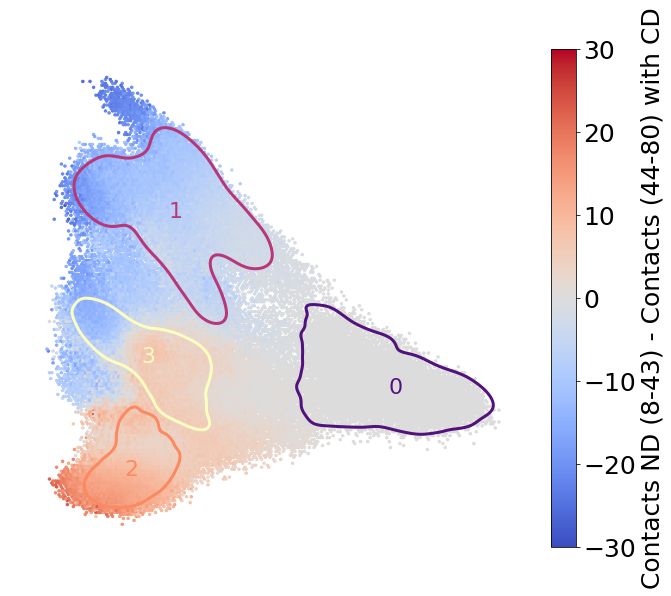

In [16]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})


fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
#Plot hexbin map of domain interface counts 

hex_map = ax.hexbin(pca_embedding[:, 0], 
                    pca_embedding[:, 1],
                    C = np.sum(contacts_ND_with_CD[:, 0:36], axis = 1)-  # First section (Leu8-Val43), resulting in positive (red) contact counts. 0-indexed, starting at 7.
                    np.sum(contacts_ND_with_CD[:, 36:73], axis = 1), # Second section(Pro44-Val80), resulting in negative contact counts.  0-indexed and starting at 7.
                    cmap = 'coolwarm',
                    mincnt =1, 
                    gridsize = 200, 
                    vmin=-30, vmax=30)
cb = fig.colorbar(hex_map, label = "Contacts ND (8-43) - Contacts (44-80) with CD")
cb.set_alpha(1)
cb.draw_all()
ax.set_axis_off()

#Overlay the cluster outlines
for cluster in range(4): 
    if cluster > -1:
        cluster_points = pca_embedding[np.where(cluster_ids_PCA == cluster)][::10]
        kdeplot = sns.kdeplot(x = cluster_points[:,0], 
                    y = cluster_points[:,1], 
                    fill = False,
                    levels = 1,
                    color = cmap(cluster+1), 
                    linewidths =3)
        kdeplot.clabel = "102"
        cluster_center_x = np.mean(pca_embedding[np.where(cluster_ids_PCA == cluster), 0])
        cluster_center_y = np.mean(pca_embedding[np.where(cluster_ids_PCA == cluster), 1])
        ax.text(cluster_center_x, 
                cluster_center_y,  
                cluster, 
                horizontalalignment='center',
                verticalalignment='center',
                size = 22, 
                color = cmap(cluster+1))